In [2]:
!pip install transformers datasets evaluate scikit-learn pandas matplotlib seaborn accelerate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [3]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'Tesla T4')

In [4]:
from google.colab import files
uploaded = files.upload()  # choose your CSV file


Saving emotion_labels.csv to emotion_labels.csv
Saving emotions-dataset.csv to emotions-dataset.csv


In [5]:
import pandas as pd

df_data = pd.read_csv("emotions-dataset.csv")   # adjust name if .tsv or .txt
df_labels = pd.read_csv("emotion_labels.csv")

print("Dataset columns:", df_data.columns)
print("Label file columns:", df_labels.columns)
df_data.head(), df_labels.head()


Dataset columns: Index(['content', 'sentiment'], dtype='object')
Label file columns: Index(['label', 'emotion'], dtype='object')


(                                             content  sentiment
 0                   not a very good day at the house          1
 1  tommcfly i saw you on tues and last niiiighht ...          2
 2     i dont even understand the intro to this book           3
 3      happy mothers day mommy and grandma haha  ily          0
 4  quotoh i got so fucked up last nightquot but u...          3,
    label  emotion
 0      0      Joy
 1      1  Sadness
 2      2  Neutral
 3      3    Anger)

In [6]:
print("df_data columns:", df_data.columns.tolist())
print("df_labels columns:", df_labels.columns.tolist())

# Also show the first few rows
print("\nSample from df_data:")
print(df_data.head())

print("\nSample from df_labels:")
print(df_labels.head())


df_data columns: ['content', 'sentiment']
df_labels columns: ['label', 'emotion']

Sample from df_data:
                                             content  sentiment
0                   not a very good day at the house          1
1  tommcfly i saw you on tues and last niiiighht ...          2
2     i dont even understand the intro to this book           3
3      happy mothers day mommy and grandma haha  ily          0
4  quotoh i got so fucked up last nightquot but u...          3

Sample from df_labels:
   label  emotion
0      0      Joy
1      1  Sadness
2      2  Neutral
3      3    Anger


In [7]:
import pandas as pd

# Merge using sentiment (data) and label (mapping)
df = pd.merge(df_data, df_labels, left_on="sentiment", right_on="label", how="left")

# Keep only useful columns and rename for consistency
# Explicitly select the 'emotion' column from df_labels and rename it to 'label'
df = df[['content', 'emotion']].rename(columns={"content": "text", "emotion": "label"})

df.head()

,text,label
0,not a very good day at the house,Sadness
1,tommcfly i saw you on tues and last niiiighht ...,Neutral
2,i dont even understand the intro to this book,Anger
3,happy mothers day mommy and grandma haha ily,Joy
4,quotoh i got so fucked up last nightquot but u...,Anger


In [8]:
type(df['label'])


pandas.core.series.Series

In [9]:
print(type(df['label']))
print(df['label'].head())
print(df['label'].unique())

<class 'pandas.core.series.Series'>
0    Sadness
1    Neutral
2      Anger
3        Joy
4      Anger
Name: label, dtype: object
['Sadness' 'Neutral' 'Anger' 'Joy']


In [10]:
from sklearn.model_selection import train_test_split
import re

def clean_text(s):
    s = str(s).strip()
    s = re.sub(r'\s+', ' ', s)
    return s

df['text'] = df['text'].apply(clean_text)
df = df.dropna()

# map labels to numeric IDs
label2id = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
id2label = {v: k for k, v in label2id.items()}
df['label_id'] = df['label'].map(label2id)

# split
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label_id'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label_id'], random_state=42)

len(train_df), len(val_df), len(test_df)

(17860, 1985, 2205)

In [11]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df[['text', 'label_id']])
val_ds   = Dataset.from_pandas(val_df[['text', 'label_id']])
test_ds  = Dataset.from_pandas(test_df[['text', 'label_id']])

dataset = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label_id', '__index_level_0__'],
        num_rows: 17860
    })
    validation: Dataset({
        features: ['text', 'label_id', '__index_level_0__'],
        num_rows: 1985
    })
    test: Dataset({
        features: ['text', 'label_id', '__index_level_0__'],
        num_rows: 2205
    })
})

In [14]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.rename_column("label_id", "labels")
tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/17860 [00:00<?, ? examples/s]

Map:   0%|          | 0/1985 [00:00<?, ? examples/s]

Map:   0%|          | 0/2205 [00:00<?, ? examples/s]

In [21]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

num_labels = len(label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

training_args = TrainingArguments(
    output_dir="./checkpoints_bert",
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1068535966.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"


In [22]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.867700,0.831318,0.649874,0.644844
2,0.649400,0.840668,0.668514,0.670778
3,0.437200,0.991114,0.662469,0.661131


TrainOutput(global_step=3351, training_loss=0.6694496402951078, metrics={'train_runtime': 477.5101, 'train_samples_per_second': 112.207, 'train_steps_per_second': 7.018, 'total_flos': 3524435874385920.0, 'train_loss': 0.6694496402951078, 'epoch': 3.0})

In [23]:
metrics = trainer.evaluate(tokenized["test"])
metrics


{'eval_loss': 0.8777877688407898,
 'eval_accuracy': 0.6571428571428571,
 'eval_f1': 0.6603642537904619,
 'eval_runtime': 3.6065,
 'eval_samples_per_second': 611.389,
 'eval_steps_per_second': 19.132,
 'epoch': 3.0}

In [31]:
import torch

def predict(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    tokens = {k: v.to(model.device) for k,v in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_id = torch.argmax(probs, dim=-1).item()
    return {
        "text": text,
        "pred_label": id2label[pred_id],
        "probs": {id2label[i]: float(probs[0][i]) for i in range(num_labels)}
    }

# Try a few examples
examples = ["I'm thrilled about this news!",
    "Feeling fantastic today!",
    "What a wonderful experience!",
    "This made me so happy!",
    "I'm smiling from ear to ear!", "I am so happy today!", "This makes me furious!", "I'm feeling a bit down.", "Hi, how are you?", "i hate you.", "yeyyy! i finally won this match", "Get out of here"]
for ex in examples:
    print(predict(ex))


{'text': "I'm thrilled about this news!", 'pred_label': 'Neutral', 'probs': {'Anger': 0.0018340692622587085, 'Joy': 0.012899916619062424, 'Neutral': 0.9783172607421875, 'Sadness': 0.006948796100914478}}
{'text': 'Feeling fantastic today!', 'pred_label': 'Neutral', 'probs': {'Anger': 0.0009255202603526413, 'Joy': 0.021134283393621445, 'Neutral': 0.9684779047966003, 'Sadness': 0.009462226182222366}}
{'text': 'What a wonderful experience!', 'pred_label': 'Neutral', 'probs': {'Anger': 0.001741112326271832, 'Joy': 0.01344971265643835, 'Neutral': 0.9752064347267151, 'Sadness': 0.009602694772183895}}
{'text': 'This made me so happy!', 'pred_label': 'Neutral', 'probs': {'Anger': 0.001468706177547574, 'Joy': 0.010239740833640099, 'Neutral': 0.9788074493408203, 'Sadness': 0.009484095498919487}}
{'text': "I'm smiling from ear to ear!", 'pred_label': 'Neutral', 'probs': {'Anger': 0.004947522189468145, 'Joy': 0.03177766129374504, 'Neutral': 0.95301353931427, 'Sadness': 0.010261296294629574}}
{'text

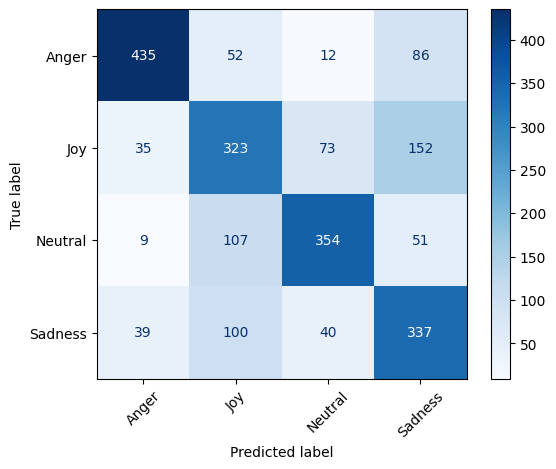

In [28]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(num_labels)])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

In [29]:
from sklearn.metrics import classification_report
import numpy as np

preds = trainer.predict(tokenized["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

from sklearn.metrics import classification_report
print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(len(id2label))],
    digits=3
))


              precision    recall  f1-score   support

       Anger      0.840     0.744     0.789       585
         Joy      0.555     0.554     0.555       583
     Neutral      0.739     0.679     0.708       521
     Sadness      0.538     0.653     0.590       516

    accuracy                          0.657      2205
   macro avg      0.668     0.658     0.660      2205
weighted avg      0.670     0.657     0.661      2205



In [32]:
# 🧠 Save fine-tuned model and tokenizer
save_dir = "bert_emotion_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"Model and tokenizer saved in folder: {save_dir}")


Model and tokenizer saved in folder: bert_emotion_model


In [33]:
!zip -r bert_emotion_model.zip bert_emotion_model
from google.colab import files
files.download("bert_emotion_model.zip")


  adding: bert_emotion_model/ (stored 0%)
  adding: bert_emotion_model/config.json (deflated 52%)
  adding: bert_emotion_model/model.safetensors (deflated 7%)
  adding: bert_emotion_model/special_tokens_map.json (deflated 42%)
  adding: bert_emotion_model/vocab.txt (deflated 53%)
  adding: bert_emotion_model/tokenizer_config.json (deflated 75%)
  adding: bert_emotion_model/tokenizer.json (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>